In [ ]:
# get only peaks that are in both replicates for each timepoint, and take the peak from the first replicate
# peaks must overlap by at least half  

! cd /home/briando/data/files/221028Van/results/macs2
! parallel -j 8 "bedtools intersect -a 633_{}_rep1_peaks.narrowPeak \
-b 633_{}_rep2_peaks.narrowPeak -f 0.5 -r -wa > 633_{}_peaks_comb.bed" ::: sgNTC_DMSO sgNTC_HU sgNTC_E2wd sgSpi1_DMSO sgSpi1_HU sgSpi1_E2wd

# make a single file of all peaks, disallowing 50bp overlap
! cat *_peaks_comb.bed | sort -k1,1 -k2,2n | bedtools merge -i - -d 50 > 221107_bd355_all_peaks.bed
! awk 'BEGIN {{OFS="\t"; print("GeneID", "Chr", "Start", "End", "Strand")}}; \
      {{print("peak" NR,$1,$2,$3,"+")}}' 221107_bd355_all_peaks.bed > \
      221107_bd355_all_peaks.saf

# featureCounts
# -p is paired-end, -T is threads, -O is allowing multi overlap, -M is a multimapper, 
# --fraction relates to both -M and -O
! module load subread
featureCounts -T 10 -p -O -M --fraction -F SAF -a 221107_bd355_all_peaks.saf \
-o 221107_bd355_atac_peak_counts.txt \
/home/briando/data/files/221028Van/results/bowtie2_bam/633_sgNTC_DMSO_rep1_aligned_reads_sorted_nodup_noblacklist_noM.bam \
/home/briando/data/files/221028Van/results/bowtie2_bam/633_sgNTC_DMSO_rep2_aligned_reads_sorted_nodup_noblacklist_noM.bam \
/home/briando/data/files/221028Van/results/bowtie2_bam/633_sgNTC_E2wd_rep1_aligned_reads_sorted_nodup_noblacklist_noM.bam \
/home/briando/data/files/221028Van/results/bowtie2_bam/633_sgNTC_E2wd_rep2_aligned_reads_sorted_nodup_noblacklist_noM.bam \
/home/briando/data/files/221028Van/results/bowtie2_bam/633_sgNTC_HU_rep1_aligned_reads_sorted_nodup_noblacklist_noM.bam \
/home/briando/data/files/221028Van/results/bowtie2_bam/633_sgNTC_HU_rep2_aligned_reads_sorted_nodup_noblacklist_noM.bam \
/home/briando/data/files/221028Van/results/bowtie2_bam/633_sgSpi1_DMSO_rep1_aligned_reads_sorted_nodup_noblacklist_noM.bam \
/home/briando/data/files/221028Van/results/bowtie2_bam/633_sgSpi1_DMSO_rep2_aligned_reads_sorted_nodup_noblacklist_noM.bam \
/home/briando/data/files/221028Van/results/bowtie2_bam/633_sgSpi1_E2wd_rep1_aligned_reads_sorted_nodup_noblacklist_noM.bam \
/home/briando/data/files/221028Van/results/bowtie2_bam/633_sgSpi1_E2wd_rep2_aligned_reads_sorted_nodup_noblacklist_noM.bam \
/home/briando/data/files/221028Van/results/bowtie2_bam/633_sgSpi1_HU_rep1_aligned_reads_sorted_nodup_noblacklist_noM.bam \
/home/briando/data/files/221028Van/results/bowtie2_bam/633_sgSpi1_HU_rep2_aligned_reads_sorted_nodup_noblacklist_noM.bam

In [2]:
library(edgeR)
library(ComplexHeatmap)
library(RColorBrewer)
library(circlize)
library(TxDb.Mmusculus.UCSC.mm10.knownGene)
library(ChIPseeker)
library(ggplot2)

## Load in data and calc diff peaks

In [3]:
setwd("~/Dropbox (MIT)/MVH_Code/brq/bd355/code")
df = read.table("../data/221107_bd355_atac_peak_counts.txt", header = TRUE, row.names=1)
peak_info = df[,1:5]
df = df[,6:dim(df)[2]]
colnames(df) = c("nd1", "nd2", "ne1", "ne2", "nh1", "nh2",
                 "pd1", "pd2", "pe1", "pe2", "ph1", "ph2")
head(df)

,nd1,nd2,ne1,ne2,nh1,nh2,pd1,pd2,pe1,pe2,ph1,ph2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
peak1,26,37,46,75,46,36,0,2,15,3,5,9
peak2,28,64,81,98,80,60,2,1,10,4,9,8
peak3,14,11,3,10,18,16,3,1,1,1,3,12
peak4,16,11,10,24,46,39,2,3,1,0,3,4
peak5,213,284,316,362,278,176,17,27,38,23,56,35
peak6,233,301,56,76,234,162,256,247,61,25,304,281


In [3]:
bedfile = peak_info[,1:3]
bedfile[,4] = rownames(bedfile)
write.table(bedfile, "../output/221108_bd355_atac_peaks.bed", sep='\t', quote=F, col.names=F, row.names=F)

In [3]:
# differential peaks
d0 <- DGEList(df)
d0 <- calcNormFactors(d0, method="TMM")
cutoff <- 2
drop <- which(apply(cpm(d0), 1, max) < cutoff)
d <- d0[-drop,] 
dim(d) # number of genes left

[1] 80732    12

In [4]:
# conditions for differential peak calling
conds = as.character(sapply(names(df), function(x) substr(x, 1, 2)))
conds

# normalize
mm <- model.matrix(~0 + conds)
y <- voom(d, mm, plot = F)
fit <- lmFit(y, mm)
head(coef(fit))

norm_expr = y$E

[1] "nd" "nd" "ne" "ne" "nh" "nh" "pd" "pd" "pe" "pe" "ph" "ph"

,condsnd,condsne,condsnh,condspd,condspe,condsph
peak1,2.2388101,3.0187874,2.1583205,-2.592715,0.6055302,-0.4712144
peak2,2.7348974,3.6071070,2.9234764,-1.783569,0.3399464,-0.1574052
peak3,0.8725354,-0.2474029,0.9056635,-1.522779,-1.9731927,-0.5990738
peak4,0.9501397,1.1475357,2.2074121,-1.217267,-2.6853336,-1.3363573
peak5,5.2012969,5.5241952,4.6038541,1.664128,2.3861843,2.1597805
peak6,5.3052805,3.1637567,4.4139249,5.217826,2.8679509,4.8685665


In [6]:
# get differentially accessible peaks for each condition
process_res = function(res) {
    tmp <- contrasts.fit(fit, res)
    tmp <- eBayes(tmp)
    res <- topTable(tmp, sort.by = "P", n = Inf)
    return(res)
}


pd_vs_nd = process_res(makeContrasts("condspd - condsnd", levels = colnames(coef(fit))))
ph_vs_pd = process_res(makeContrasts("condsph - condspd", levels = colnames(coef(fit))))
nh_vs_nd = process_res(makeContrasts("condsnh - condsnd", levels = colnames(coef(fit))))
ne_vs_nd = process_res(makeContrasts("condsne - condsnd", levels = colnames(coef(fit))))
pe_vs_pd = process_res(makeContrasts("condspe - condspd", levels = colnames(coef(fit))))



In [124]:
dim(subset(pd_vs_nd, logFC < -1 & adj.P.Val < 0.05))
dim(subset(pd_vs_nd, logFC > 1 & adj.P.Val < 0.05))

[1] 12322     6

[1] 6068    6

In [7]:
dim(subset(ne_vs_nd, logFC < -1 & adj.P.Val < 0.05))
dim(subset(ne_vs_nd, logFC > 1 & adj.P.Val < 0.05))

dim(subset(nh_vs_nd, logFC < -1 & adj.P.Val < 0.05))
dim(subset(nh_vs_nd, logFC > 1 & adj.P.Val < 0.05))

dim(subset(pe_vs_pd, logFC < -1 & adj.P.Val < 0.05))
dim(subset(pe_vs_pd, logFC > 1 & adj.P.Val < 0.05))

dim(subset(ph_vs_pd, logFC < -1 & adj.P.Val < 0.05))
dim(subset(ph_vs_pd, logFC > 1 & adj.P.Val < 0.05))

[1] 11568     6

[1] 11369     6

[1] 2001    6

[1] 6074    6

[1] 9079    6

[1] 8069    6

[1] 655   6

[1] 4441    6

In [8]:
# gained in PH but not in NH
# 1265 overlaps
ph_up = subset(ph_vs_pd, logFC > 1 & adj.P.Val < 0.05)  # 3668
dim(ph_up)
nh_up = subset(nh_vs_nd, logFC > 1 & adj.P.Val < 0.05)  # 4727
dim(nh_up)
pe_up = subset(pe_vs_pd, logFC > 1 & adj.P.Val < 0.05)  # 6900
dim(pe_up)
ne_up = subset(ne_vs_nd, logFC > 1 & adj.P.Val < 0.05)  # 9342
dim(ne_up)

[1] 4441    6

[1] 6074    6

[1] 8069    6

[1] 11369     6

In [32]:
length(intersect(rownames(ph_up), rownames(pe_up)))

[1] 1987

In [9]:
a = intersect(rownames(nh_up), rownames(ph_up))
length(a)  # 1428
b = intersect(rownames(ne_up), rownames(pe_up))
length(b) # 5100

[1] 1428

[1] 5100

In [10]:
nh_not_ne = setdiff(rownames(nh_up), rownames(ne_up))
length(nh_not_ne)  # 3040
ph_not_pe = setdiff(rownames(ph_up), rownames(pe_up))
length(ph_not_pe)  # 2454
nh_and_ph = intersect(nh_not_ne, ph_not_pe)
length(nh_and_ph)  # 537

[1] 3040

[1] 2454

[1] 537

In [11]:
ne_not_nh = setdiff(rownames(ne_up), rownames(nh_up))
length(ne_not_nh)  # 8335
pe_not_ph = setdiff(rownames(pe_up), rownames(ph_up))
length(pe_not_ph)  # 6082
ne_and_pe = intersect(ne_not_nh, pe_not_ph)
length(ne_and_pe)  # 3126

[1] 8335

[1] 6082

[1] 3126

In [31]:
nh_and_ph

[1] "peak42035" "peak18219" "peak75768" "peak85807" "peak17189" "peak153"  
  [7] "peak47678" "peak62145" "peak28248" "peak27106" "peak17192" "peak68135"
 [13] "peak49609" "peak42202" "peak47672" "peak31662" "peak47643" "peak19065"
 [19] "peak68062" "peak46908" "peak87091" "peak17801" "peak25612" "peak72383"
 [25] "peak77897" "peak51539" "peak69377" "peak8566"  "peak62044" "peak17074"
 [31] "peak61901" "peak42032" "peak82777" "peak17860" "peak28250" "peak41829"
 [37] "peak3795"  "peak24988" "peak51530" "peak82909" "peak28525" "peak33266"
 [43] "peak11214" "peak69709" "peak21231" "peak53972" "peak24242" "peak19131"
 [49] "peak60638" "peak56853" "peak21232" "peak80599" "peak42410" "peak70985"
 [55] "peak19990" "peak456"   "peak27698" "peak61804" "peak31264" "peak38418"
 [61] "peak43160" "peak45500" "peak57363" "peak61482" "peak76314" "peak57313"
 [67] "peak49671" "peak16258" "peak61411" "peak20500" "peak52090" "peak60561"
 [73] "peak82810" "peak16970" "peak26948" "peak22980" "peak16893" "peak10720"
 [79] "peak85578" "peak57761" "peak43528" "peak25613" "peak17773" "peak33176"
 [85] "peak24004" "peak888"   "peak27653" "peak38618" "peak31589" "peak13169"
 [91] "peak6859"  "peak32487" "peak13113" "peak40540" "peak46524" "peak25636"
 [97] "peak18639" "peak24193" "peak126"   "peak68138" "peak55529" "peak47674"
[103] "peak26306" "peak31711" "peak36400" "peak1497"  "peak26465" "peak75454"
[109] "peak32450" "peak51901" "peak10877" "peak76903" "peak46750" "peak83960"
[115] "peak83961" "peak29037" "peak47166" "peak42858" "peak51630" "peak57197"
[121] "peak18434" "peak63235" "peak12004" "peak42036" "peak53863" "peak71790"
[127] "peak26602" "peak26299" "peak38905" "peak71131" "peak5751"  "peak16874"
[133] "peak14202" "peak24513" "peak5041"  "peak30872" "peak56204" "peak73971"
[139] "peak17605" "peak50775" "peak47665" "peak17783" "peak51144" "peak62995"
[145] "peak61988" "peak62770" "peak427"   "peak63362" "peak59336" "peak17156"
[151] "peak11900" "peak60116" "peak15597" "peak82177" "peak28247" "peak60479"
[157] "peak1262"  "peak56149" "peak33149" "peak16901" "peak16873" "peak38421"
[163] "peak31306" "peak14876" "peak77540" "peak55965" "peak16838" "peak22981"
[169] "peak73757" "peak48427" "peak11098" "peak45288" "peak68609" "peak69459"
[175] "peak84063" "peak44840" "peak53808" "peak24506" "peak18892" "peak66217"
[181] "peak34761" "peak12525" "peak19753" "peak132"   "peak38337" "peak27351"
[187] "peak861"   "peak81650" "peak61401" "peak20696" "peak57033" "peak61947"
[193] "peak17358" "peak24186" "peak55843" "peak79137" "peak56917" "peak51616"
[199] "peak44831" "peak79989" "peak23277" "peak24217" "peak87678" "peak74226"
[205] "peak23392" "peak29099" "peak31225" "peak72361" "peak22210" "peak44841"
[211] "peak29944" "peak32510" "peak42033" "peak18100" "peak55275" "peak61994"
[217] "peak32486" "peak61406" "peak76975" "peak299"   "peak57892" "peak64872"
[223] "peak73767" "peak85934" "peak17066" "peak43630" "peak10715" "peak49603"
[229] "peak45025" "peak43166" "peak17557" "peak24713" "peak63818" "peak60537"
[235] "peak39191" "peak44288" "peak85659" "peak40043" "peak38852" "peak26840"
[241] "peak39548" "peak73323" "peak17051" "peak53016" "peak5693"  "peak10453"
[247] "peak70113" "peak244"   "peak61151" "peak26943" "peak3510"  "peak70318"
[253] "peak39476" "peak46743" "peak37198" "peak63100" "peak81938" "peak52669"
[259] "peak37144" "peak31295" "peak18622" "peak44779" "peak36833" "peak56378"
[265] "peak24306" "peak79875" "peak80331" "peak307"   "peak45292" "peak32500"
[271] "peak53448" "peak26422" "peak20520" "peak79677" "peak52382" "peak73765"
[277] "peak12529" "peak32407" "peak56397" "peak76349" "peak446"   "peak44654"
[283] "peak56580" "peak64285" "peak34760" "peak59410" "peak57488" "peak46965"
[289] "peak51123" "peak20424" "peak42981" "peak27099" "peak57857" "peak51699"
[295] "peak27027" "peak42534" "peak63194" "peak1840"  "peak66696" "peak85212"
[301] "peak67851" "peak47292" "peak79128" "peak19793" "peak28587" "peak31636"
[307] "peak67168" "peak5

In [14]:
g = "peak51728"
nh_vs_nd[g,]
ph_vs_pd[g,]
pe_vs_pd[g,]
peak_info[g,]

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
peak51728,2.209774,2.332338,6.209197,1.460977e-06,4.355525e-05,4.388927


,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
peak51728,1.756059,2.332338,8.888863,2.394092e-09,1.571381e-06,10.71048


,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
peak51728,0.6702622,2.332338,2.89681,0.007565312,0.02688927,-3.119316


,Chr,Start,End,Strand,Length
,<chr>,<int>,<int>,<chr>,<int>
peak51728,chr3,27563006,27563672,+,667


In [15]:
# up in PU.1 HU but not in PU.1 -E2
ph_up[nh_and_ph]

ERROR: Error in `[.data.frame`(ph_up, nh_and_ph): undefined columns selected


In [17]:
g = "peak62930"
ne_vs_nd[g,]
pe_vs_pd[g,]
peak_info[g,]

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
peak62930,1.735007,2.017856,5.042339,3.034224e-05,0.0001944273,2.334162


,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
peak62930,2.593542,2.017856,8.463902,6.224181e-09,2.324837e-07,10.59365


,Chr,Start,End,Strand,Length
,<chr>,<int>,<int>,<chr>,<int>
peak62930,chr5,88580061,88581069,+,1009


In [84]:
ne_up[setdiff(rownames(ne_up), rownames(pe_up)),]

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
peak41136,2.024684,3.881534,14.89157,3.474295e-13,6.033692e-11,20.27368
peak82890,1.575590,5.452966,14.42369,6.700291e-13,9.754820e-11,19.53314
peak64860,1.700311,4.688316,13.97986,1.269674e-12,1.542296e-10,18.87950
peak17462,1.878458,4.251961,13.93659,1.352492e-12,1.607753e-10,18.92939
peak14509,1.617930,4.650407,13.88187,1.465340e-12,1.711394e-10,18.72596
peak28213,1.643877,4.405933,13.77354,1.718547e-12,1.932655e-10,18.61540
peak78339,2.155489,3.891348,13.66875,2.006930e-12,2.183342e-10,18.50580
peak62343,1.281504,4.871272,13.17841,4.200648e-12,3.837436e-10,17.58472
peak77759,1.357614,5.082272,13.15737,4.337985e-12,3.935939e-10,17.57971


In [13]:
norm_expr = y$E
head(norm_expr)

,nd1,nd2,ne1,ne2,nh1,nh2,pd1,pd2,pe1,pe2,ph1,ph2
peak1,2.246865,2.2329767,2.7242861,3.2919609,2.1091103,2.223606,-3.881934,-1.3034959,0.9689942,-0.1630726,-0.86504869,-0.0777203
peak2,2.351835,3.0153852,3.5338554,3.6756080,2.9008684,2.952645,-1.560005,-2.0404615,0.4071153,0.1994974,-0.07655279,-0.2381850
peak3,1.376926,0.5277199,-1.0075178,0.4458736,0.7794049,1.078176,-1.074579,-2.0404615,-2.4002396,-1.3854651,-1.51712539,0.3182084
peak4,1.563339,0.5277199,0.5774447,1.6682660,2.1091103,2.337562,-1.560005,-0.8180691,-2.4002396,-2.9704276,-1.51712539,-1.1557228
peak5,5.257037,5.1564428,5.4911889,5.5553934,4.6914850,4.497306,1.247350,2.1559357,2.2815844,2.5841613,2.49569865,1.8240993
peak6,5.386223,5.2401722,3.0053062,3.3109440,4.4433956,4.378078,5.120882,5.3258607,2.9573124,2.7019978,4.92581811,4.8113433


## Enhancers only

In [89]:
# get GRanges object for all my peaks
peak_ranges = GRanges(seqnames=peak_info$Chr,
                      ranges=IRanges(start=peak_info$Start,
                                     end=peak_info$End),
                      peak_id=rownames(peak_info))
peak_ranges


GRanges object with 87786 ranges and 1 metadata column:
          seqnames            ranges strand |     peak_id
             <Rle>         <IRanges>  <Rle> | <character>
      [1]     chr1   3052521-3053005      * |       peak1
      [2]     chr1   3059485-3059972      * |       peak2
      [3]     chr1   3083465-3083819      * |       peak3
      [4]     chr1   3104810-3105387      * |       peak4
      [5]     chr1   3445468-3446288      * |       peak5
      ...      ...               ...    ... .         ...
  [87782]     chrY 90822513-90822947      * |   peak87782
  [87783]     chrY 90825128-90825405      * |   peak87783
  [87784]     chrY 90826598-90826845      * |   peak87784
  [87785]     chrY 90828367-90829319      * |   peak87785
  [87786]     chrY 90839682-90839927      * |   peak87786
  -------
  seqinfo: 21 sequences from an unspecified genome; no seqlengths

In [91]:
# annotate all peaks
# defining the promoter as +/- 2kb from known TSS's
txdb = TxDb.Mmusculus.UCSC.mm10.knownGene
peakAnno <- as.data.frame(annotatePeak(peak_ranges, tssRegion=c(-2000, 2000),
                     TxDb=txdb, annoDb="org.Mm.eg.db"))
peakAnno$annobrief = sapply(peakAnno$annotation, function(x) strsplit(x, ' ') [[1]][1])
peakAnno$annobrief[peakAnno$annobrief == "5'"] = "5' UTR"
peakAnno$annobrief[peakAnno$annobrief == "3'"] = "3' UTR"
peakAnno$annobrief[peakAnno$annobrief == "Distal"] = "Intergenic"
peakAnno$annobrief[peakAnno$annobrief == "Downstream"] = "TTS"
head(peakAnno)

>> preparing features information...		 2023-06-11 14:31:24 
>> identifying nearest features...		 2023-06-11 14:31:24 
>> calculating distance from peak to TSS...	 2023-06-11 14:31:25 
>> assigning genomic annotation...		 2023-06-11 14:31:25 
>> adding gene annotation...			 2023-06-11 14:31:26 


Loading required package: org.Mm.eg.db



'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2023-06-11 14:31:26 
>> done...					 2023-06-11 14:31:26 


,seqnames,start,end,width,strand,peak_id,annotation,geneChr,geneStart,geneEnd,geneLength,geneStrand,geneId,transcriptId,distanceToTSS,ENSEMBL,SYMBOL,GENENAME,annobrief
,<fct>,<int>,<int>,<int>,<fct>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,chr1,3052521,3053005,485,*,peak1,Distal Intergenic,1,3214482,3671498,457017,2,497097,ENSMUST00000070533.4,618493,ENSMUSG00000051951,Xkr4,X-linked Kx blood group related 4,Intergenic
2,chr1,3059485,3059972,488,*,peak2,Distal Intergenic,1,3214482,3671498,457017,2,497097,ENSMUST00000070533.4,611526,ENSMUSG00000051951,Xkr4,X-linked Kx blood group related 4,Intergenic
3,chr1,3083465,3083819,355,*,peak3,Distal Intergenic,1,3214482,3671498,457017,2,497097,ENSMUST00000070533.4,587679,ENSMUSG00000051951,Xkr4,X-linked Kx blood group related 4,Intergenic
4,chr1,3104810,3105387,578,*,peak4,Distal Intergenic,1,3214482,3671498,457017,2,497097,ENSMUST00000070533.4,566111,ENSMUSG00000051951,Xkr4,X-linked Kx blood group related 4,Intergenic
5,chr1,3445468,3446288,821,*,peak5,"Intron (ENSMUST00000070533.4/497097, intron 1 of 2)",1,3214482,3671498,457017,2,497097,ENSMUST00000070533.4,225210,ENSMUSG00000051951,Xkr4,X-linked Kx blood group related 4,Intron
6,chr1,3451360,3452047,688,*,peak6,"Intron (ENSMUST00000070533.4/497097, intron 1 of 2)",1,3214482,3671498,457017,2,497097,ENSMUST00000070533.4,219451,ENSMUSG00000051951,Xkr4,X-linked Kx blood group related 4,Intron


In [92]:
tss_peaks = unique(subset(peakAnno, annobrief == "Promoter")$peak_id)
enh_peaks = unique(subset(peakAnno, annobrief != "Promoter")$peak_id)
length(tss_peaks)
length(enh_peaks)

[1] 22458

[1] 65328

## Priming

### Silent enh

[1] 58890

[1] 1135

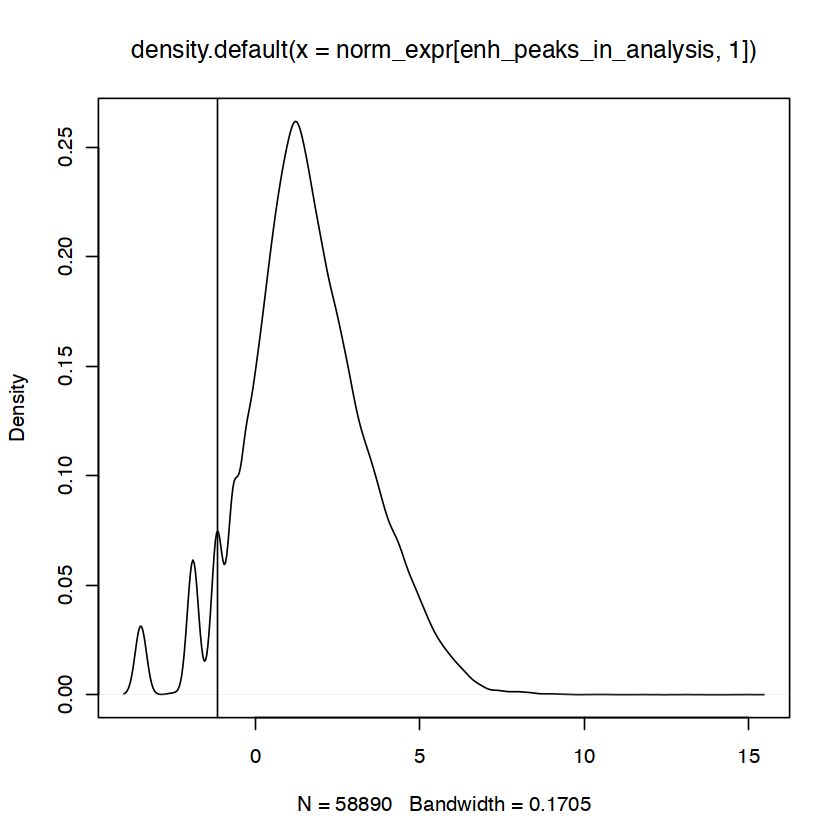

In [93]:
# what is a silent enhancer

enh_peaks_in_analysis = intersect(enh_peaks, rownames(nh_vs_nd))
length(enh_peaks_in_analysis)

# 10th percentile of peaks in baseline will be called "silent"
q1 = quantile(norm_expr[enh_peaks_in_analysis,1], 0.05)[[1]]
q2 = quantile(norm_expr[enh_peaks_in_analysis,2], 0.05)[[1]]

## Looking specifically at peaks with low/undetectable ATAC early
plot(density(norm_expr[enh_peaks_in_analysis,1]))
abline(v=q1)

# making a list of silent peaks
silent_enh1 = intersect(enh_peaks_in_analysis, rownames(norm_expr[norm_expr[,1] < q1,]))
silent_enh2 = intersect(enh_peaks_in_analysis, rownames(norm_expr[norm_expr[,2] < q2,]))
silent_enhs = intersect(silent_enh1, silent_enh2)
length(silent_enhs)

In [101]:
length(intersect(nh_only, silent_enhs))  # 92 out of 2213 = 4%
length(intersect(ne_only, silent_enhs)) # 419 out of 6828 = 18%

[1] 60

[1] 708

### Peaks going up/down

In [94]:
# Looking at peaks that go up

nh_up = rownames(subset(nh_vs_nd, logFC > 1 & adj.P.Val < 0.05 & rownames(nh_vs_nd) %in% enh_peaks))  # 5448
ne_up = rownames(subset(ne_vs_nd, logFC > 1 & adj.P.Val < 0.05 & rownames(ne_vs_nd) %in% enh_peaks))  # 9914

nh_only = setdiff(nh_up, ne_up)  # 2756
shared_n = intersect(nh_up, ne_up)  # 2692
ne_only = setdiff(ne_up, nh_up)  # 7222

ph_up = rownames(subset(ph_vs_pd, logFC > 1 & adj.P.Val < 0.05 & rownames(ph_vs_pd) %in% enh_peaks))  # 3933
pe_up = rownames(subset(pe_vs_pd, logFC > 1 & adj.P.Val < 0.05 & rownames(pe_vs_pd) %in% enh_peaks))  # 6950

ph_only = setdiff(ph_up, pe_up)  # 2172
shared_p = intersect(ph_up, pe_up)  # 1761
pe_only = setdiff(pe_up, ph_up)  # 5189

nh_vs_ph__nh = setdiff(nh_up, ph_up)  # 4169
nh_vs_ph__shared = intersect(nh_up, ph_up)  # 1279
nh_vs_ph__ph = setdiff(ph_up, nh_up)  # 2654



In [163]:
# Comparisons

write.bed = function(fn, peaks) {
    tbl = peak_info[peaks,1:3]
    tbl[,4] = rownames(tbl)
    write.table(tbl, fn, quote=F, row.names=F, col.names=F, sep="\t")
}

# all enhancers
write.bed("230107_all_enhancers.bed", enh_peaks)

# NH vs NE: unique and shared
write.bed("230107_bd355_nh_vs_ne__nh.bed", nh_only)
write.bed("230107_bd355_nh_vs_ne__shared.bed", shared_n)
write.bed("230107_bd355_nh_vs_ne__ne.bed", ne_only)

# PH vs PE: unique and shared
write.bed("230107_bd355_ph_vs_pe__ph.bed", ph_only)
write.bed("230107_bd355_ph_vs_pe__shared.bed", shared_p)
write.bed("230107_bd355_ph_vs_pe__pe.bed", pe_only)

# NH vs PH: unique and shared
write.bed("230205_bd355_nh_vs_ph__nh.bed", nh_vs_ph__nh)
write.bed("230205_bd355_nh_vs_ph__shared.bed", nh_vs_ph__shared)
write.bed("230205_bd355_nh_vs_ph__ph.bed", nh_vs_ph__ph)

# NHnotNE vs PHnotPE: unique and shared
write.bed("230107_bd355_nhonly_vs_phonly__nh.bed", setdiff(nh_only, ph_only))
write.bed("230107_bd355_nhonly_vs_phonly__shared.bed", intersect(nh_only, ph_only))
write.bed("230107_bd355_nhonly_vs_phonly__ph.bed", setdiff(ph_only, nh_only))

# NEnotNH vs PEnotPH: unique and shared
write.bed("230107_bd355_neonly_vs_peonly__ne.bed", setdiff(ne_only, pe_only))
write.bed("230107_bd355_neonly_vs_peonly__shared.bed", intersect(ne_only, pe_only))
write.bed("230107_bd355_neonly_vs_peonly__pe.bed", setdiff(pe_only, ne_only))

# NHandNE vs PHandPE: unique and shared
write.bed("230107_bd355_nshared_vs_pshared__n.bed", setdiff(shared_n, shared_p))
write.bed("230107_bd355_nshared_vs_pshared__shared.bed", intersect(shared_n, shared_p))
write.bed("230107_bd355_nshared_vs_pshared__p.bed", setdiff(shared_p, shared_n))



In [152]:
# all vs enhancers
! parallel -j 16 --dryrun "sbatch -N 1 -n 1 -x c[5-32] --wrap \"findMotifsGenome.pl {} mm10 {.}_vsenhancers -bg 230107_all_enhancers.bed -size 200 -p 4 -mask -preparsedDir ~/data/genomes/mm10\" " ::: *bd355*.bed

# all vs genome
! parallel -j 16 --dryrun "sbatch -N 1 -n 1 -x c[5-32] --wrap \"findMotifsGenome.pl {} mm10 {.}_vsgenome -size 200 -p 4 -mask -preparsedDir ~/data/genomes/mm10\" " ::: *.bed

# vs each other
sbatch -N 1 -n 1 -x c[5-32] --wrap "findMotifsGenome.pl 230107_bd355_nh_vs_ne__nh.bed mm10 230107_bd355_nh_vs_ne__nh -bg 230107_bd355_nh_vs_ne__ne.bed -size 200 -p 4 -mask -preparsedDir ~/data/genomes/mm10"
sbatch -N 1 -n 1 -x c[5-32] --wrap "findMotifsGenome.pl 230107_bd355_nh_vs_ne__ne.bed mm10 230107_bd355_nh_vs_ne__ne -bg 230107_bd355_nh_vs_ne__nh.bed -size 200 -p 4 -mask -preparsedDir ~/data/genomes/mm10"

sbatch -N 1 -n 1 -x c[5-32] --wrap "findMotifsGenome.pl 230107_bd355_ph_vs_pe__ph.bed mm10 230107_bd355_ph_vs_pe__ph -bg 230107_bd355_ph_vs_pe__pe.bed -size 200 -p 4 -mask -preparsedDir ~/data/genomes/mm10"
sbatch -N 1 -n 1 -x c[5-32] --wrap "findMotifsGenome.pl 230107_bd355_ph_vs_pe__pe.bed mm10 230107_bd355_ph_vs_pe__pe -bg 230107_bd355_ph_vs_pe__ph.bed -size 200 -p 4 -mask -preparsedDir ~/data/genomes/mm10"

sbatch -N 1 -n 1 -x c[5-32] --wrap "findMotifsGenome.pl 230107_bd355_nhonly_vs_phonly__nh.bed mm10 230107_bd355_nhonly_vs_phonly__nh -bg 230107_bd355_nhonly_vs_phonly__ph.bed -size 200 -p 4 -mask -preparsedDir ~/data/genomes/mm10"
sbatch -N 1 -n 1 -x c[5-32] --wrap "findMotifsGenome.pl 230107_bd355_nhonly_vs_phonly__ph.bed mm10 230107_bd355_nhonly_vs_phonly__ph -bg 230107_bd355_nhonly_vs_phonly__nh.bed -size 200 -p 4 -mask -preparsedDir ~/data/genomes/mm10"

sbatch -N 1 -n 1 -x c[5-32] --wrap "findMotifsGenome.pl 230107_bd355_neonly_vs_peonly__ne.bed mm10 230107_bd355_neonly_vs_peonly__ne -bg 230107_bd355_neonly_vs_peonly__pe.bed -size 200 -p 4 -mask -preparsedDir ~/data/genomes/mm10"
sbatch -N 1 -n 1 -x c[5-32] --wrap "findMotifsGenome.pl 230107_bd355_neonly_vs_peonly__pe.bed mm10 230107_bd355_neonly_vs_peonly__pe -bg 230107_bd355_neonly_vs_peonly__ne.bed -size 200 -p 4 -mask -preparsedDir ~/data/genomes/mm10"

sbatch -N 1 -n 1 -x c[5-32] --wrap "findMotifsGenome.pl 230107_bd355_nshared_vs_pshared__n.bed mm10 230107_bd355_nshared_vs_pshared__n -bg 230107_bd355_nshared_vs_pshared__p.bed -size 200 -p 4 -mask -preparsedDir ~/data/genomes/mm10"
sbatch -N 1 -n 1 -x c[5-32] --wrap "findMotifsGenome.pl 230107_bd355_nshared_vs_pshared__p.bed mm10 230107_bd355_nshared_vs_pshared__p -bg 230107_bd355_nshared_vs_pshared__n.bed -size 200 -p 4 -mask -preparsedDir ~/data/genomes/mm10"

sbatch -N 1 -n 1 -x c[5-32] --wrap "findMotifsGenome.pl 230205_bd355_nh_vs_ph__nh.bed mm10 230205_bd355_nh_vs_ph__nh -bg 230205_bd355_nh_vs_ph__ph.bed -size 200 -p 4 -mask -preparsedDir ~/data/genomes/mm10"
sbatch -N 1 -n 1 -x c[5-32] --wrap "findMotifsGenome.pl 230205_bd355_nh_vs_ph__ph.bed mm10 230205_bd355_nh_vs_ph__ph -bg 230205_bd355_nh_vs_ph__nh.bed -size 200 -p 4 -mask -preparsedDir ~/data/genomes/mm10"

[1] 500

### Baselines

In [95]:
norm_expr = as.data.frame(norm_expr)
head(norm_expr)

,nd1,nd2,ne1,ne2,nh1,nh2,pd1,pd2,pe1,pe2,ph1,ph2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
peak1,2.246865,2.2329767,2.7242861,3.2919609,2.1091103,2.223606,-3.881934,-1.3034959,0.9689942,-0.1630726,-0.86504869,-0.0777203
peak2,2.351835,3.0153852,3.5338554,3.6756080,2.9008684,2.952645,-1.560005,-2.0404615,0.4071153,0.1994974,-0.07655279,-0.2381850
peak3,1.376926,0.5277199,-1.0075178,0.4458736,0.7794049,1.078176,-1.074579,-2.0404615,-2.4002396,-1.3854651,-1.51712539,0.3182084
peak4,1.563339,0.5277199,0.5774447,1.6682660,2.1091103,2.337562,-1.560005,-0.8180691,-2.4002396,-2.9704276,-1.51712539,-1.1557228
peak5,5.257037,5.1564428,5.4911889,5.5553934,4.6914850,4.497306,1.247350,2.1559357,2.2815844,2.5841613,2.49569865,1.8240993
peak6,5.386223,5.2401722,3.0053062,3.3109440,4.4433956,4.378078,5.120882,5.3258607,2.9573124,2.7019978,4.92581811,4.8113433


In [109]:
subset(norm_expr[nh_ph_shared,])

,nd1,nd2,ne1,ne2,nh1,nh2,pd1,pd2,pe1,pe2,ph1,ph2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
peak42021,4.140996,3.964160,5.8163043,5.69560786,5.548662,5.668593,2.7179793,3.1427603,4.402815,4.267977,4.6951104,4.547796
peak42035,2.073533,2.048552,0.8289834,0.37548427,4.266919,4.121245,-0.4225019,0.2814666,-2.400240,-1.385465,1.6755197,1.740441
peak18219,4.050326,3.964160,4.2019355,4.32501920,5.391725,5.339843,4.3988373,4.0540561,4.009151,3.743818,5.1733715,5.323608
peak75768,4.443757,4.507984,4.0859941,4.12501853,5.631998,5.578746,1.2473495,1.3287723,1.796158,2.158855,2.9516441,2.834224
peak49807,3.389309,3.370480,5.2962629,5.38223110,4.776966,4.751458,2.5937999,2.2572190,4.248418,4.229245,3.8702765,3.756501
peak14561,2.073533,1.676583,2.9795431,3.04224086,3.859970,4.083630,1.8994262,1.8664291,2.204622,2.644282,3.0763991,3.075232
peak27230,3.058103,3.102190,3.6689430,3.66088648,4.449535,4.637408,1.7327763,1.7321280,3.927687,3.972087,3.4634223,3.587242
peak5039,2.010798,1.981438,5.4018731,5.43941857,4.017035,4.115931,3.1067512,3.6874590,5.586550,5.647958,4.6951104,4.826637
peak85807,3.563339,3.759045,2.4519138,2.59271498,4.927504,4.949661,1.4756185,1.8008408,1.569387,1.784460,3.1267308,2.922280


In [115]:
nh_up = rownames(subset(nh_vs_nd, logFC > 1 & adj.P.Val < 0.05 & rownames(nh_vs_nd) %in% enh_peaks))
ph_up = rownames(subset(ph_vs_pd, logFC > 1 & adj.P.Val < 0.05 & rownames(ph_vs_pd) %in% enh_peaks))

nh_up_only = setdiff(nh_up, ph_up)   # 4169
ph_up_only = setdiff(ph_up, nh_up)   # 2654
nh_ph_shared = intersect(nh_up, ph_up)  # 1279

In [119]:
nh_up_tss = rownames(subset(nh_vs_nd, logFC > 1 & adj.P.Val < 0.05 & rownames(nh_vs_nd) %in% tss_peaks))
ph_up_tss = rownames(subset(ph_vs_pd, logFC > 1 & adj.P.Val < 0.05 & rownames(ph_vs_pd) %in% tss_peaks))

nh_up_tss_only = setdiff(nh_up_tss, ph_up_tss)   # 477
ph_up_tss_only = setdiff(ph_up_tss, nh_up_tss)   # 359
nh_ph_tss_shared = intersect(nh_up_tss, ph_up_tss)  # 149

In [122]:
length(nh_ph_tss_shared)

[1] 149

In [123]:
nh_up_tss_only

[1] "peak55397" "peak70316" "peak42805" "peak78028" "peak72233" "peak64035"
  [7] "peak65734" "peak59215" "peak14553" "peak81217" "peak61646" "peak65091"
 [13] "peak72630" "peak22157" "peak43110" "peak65736" "peak69943" "peak64863"
 [19] "peak38533" "peak40721" "peak46100" "peak32578" "peak26525" "peak65737"
 [25] "peak36523" "peak45587" "peak36739" "peak65735" "peak22126" "peak79196"
 [31] "peak17425" "peak31753" "peak63956" "peak65731" "peak42068" "peak28421"
 [37] "peak43513" "peak15807" "peak87670" "peak31821" "peak82463" "peak12696"
 [43] "peak15740" "peak714"   "peak49669" "peak47334" "peak64476" "peak66922"
 [49] "peak755"   "peak43851" "peak28783" "peak74923" "peak24813" "peak31860"
 [55] "peak47832" "peak1649"  "peak67659" "peak33029" "peak85789" "peak60620"
 [61] "peak52900" "peak70317" "peak25903" "peak72458" "peak42049" "peak36018"
 [67] "peak29399" "peak38424" "peak62136" "peak26031" "peak77944" "peak72004"
 [73] "peak33181" "peak67285" "peak2836"  "peak53278" "peak6962"  "peak24579"
 [79] "peak70330" "peak65732" "peak45239" "peak10781" "peak67408" "peak34562"
 [85] "peak78036" "peak62909" "peak47591" "peak44399" "peak24438" "peak30650"
 [91] "peak85894" "peak9864"  "peak74221" "peak5528"  "peak79152" "peak43354"
 [97] "peak44228" "peak31742" "peak27108" "peak75390" "peak40194" "peak85638"
[103] "peak19299" "peak74421" "peak54967" "peak64670" "peak87508" "peak72384"
[109] "peak32415" "peak18963" "peak71879" "peak27607" "peak82448" "peak46171"
[115] "peak62534" "peak13853" "peak76511" "peak75478" "peak54085" "peak74608"
[121] "peak46991" "peak24473" "peak7066"  "peak6357"  "peak74187" "peak1798" 
[127] "peak66692" "peak4816"  "peak59305" "peak67496" "peak1164"  "peak66871"
[133] "peak32558" "peak44953" "peak24693" "peak9722"  "peak9712"  "peak69463"
[139] "peak11493" "peak74188" "peak45345" "peak28422" "peak83729" "peak8403" 
[145] "peak74050" "peak15756" "peak3736"  "peak44664" "peak39679" "peak32792"
[151] "peak48124" "peak11763" "peak61086" "peak59160" "peak74939" "peak43020"
[157] "peak14769" "peak16984" "peak72455" "peak29398" "peak86341" "peak46360"
[163] "peak85450" "peak86088" "peak2649"  "peak52486" "peak72070" "peak43111"
[169] "peak54396" "peak15168" "peak74453" "peak57067" "peak28365" "peak63707"
[175] "peak27323" "peak25753" "peak85183" "peak45635" "peak42047" "peak16024"
[181] "peak75459" "peak57408" "peak63651" "peak66441" "peak70973" "peak51532"
[187] "peak59256" "peak71024" "peak31101" "peak55857" "peak20295" "peak76079"
[193] "peak61656" "peak23280" "peak82452" "peak63283" "peak11417" "peak19845"
[199] "peak80417" "peak35713" "peak66108" "peak84021" "peak51537" "peak79436"
[205] "peak82021" "peak42050" "peak6156"  "peak27194" "peak86544" "peak60297"
[211] "peak64151" "peak39883" "peak51778" "peak61565" "peak66275" "peak76461"
[217] "peak10117" "peak70023" "peak77537" "peak7618"  "peak54141" "peak59312"
[223] "peak56855" "peak81401" "peak73551" "peak47937" "peak53040" "peak46566"
[229] "peak48010" "peak61293" "peak30007" "peak48130" "peak23065" "peak34795"
[235] "peak57116" "peak28324" "peak75570" "peak45268" "peak69597" "peak49330"
[241] "peak69020" "peak18234" "peak52507" "peak63211" "peak61341" "peak19168"
[247] "peak64152" "peak64878" "peak3841"  "peak80152" "peak74452" "peak9946" 
[253] "peak76024" "peak13268" "peak16741" "peak78046" "peak3947"  "peak67051"
[259] "peak41150" "peak66814" "peak31502" "peak68335" "peak37310" "peak64831"
[265] "peak22683" "peak6704"  "peak23852" "peak81315" "peak77983" "peak5212" 
[271] "peak7097"  "peak24897" "peak42037" "peak24933" "peak53994" "peak34077"
[277] "peak11852" "peak69391" "peak55545" "peak70333" "peak4857"  "peak6902" 
[283] "peak68973" "peak34960" "peak43704" "peak53833" "peak12786" "peak22716"
[289] "peak87388" "peak16011" "peak65281" "peak67004" "peak39561" "peak76345"
[295] "peak54147" "peak49957" "peak36775" "peak32681" "peak48265" "peak18150"
[301] "peak25288" "peak84588" "peak77323" "peak15916" "peak40168" "peak32304"
[307] "peak59433" "peak2

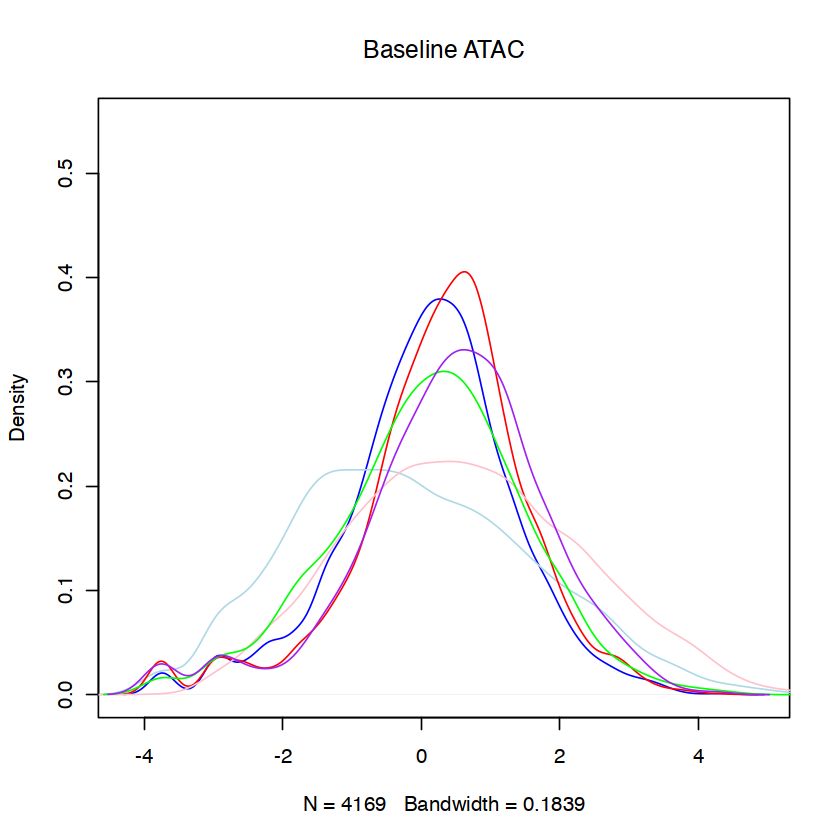

In [96]:
# Plotting the baseline ATAC of peaks that gain ATAC uniquely in each condition 

nh_up = rownames(subset(nh_vs_nd, logFC > 1 & adj.P.Val < 0.05 & rownames(nh_vs_nd) %in% enh_peaks))
#nh_up = rownames(subset(nh_vs_nd, logFC > 1 & adj.P.Val < 0.05))
#nh_up_liberal = rownames(subset(nh_vs_nd, logFC > 0 & rownames(nh_vs_nd) %in% enh_peaks))

ph_up = rownames(subset(ph_vs_pd, logFC > 1 & adj.P.Val < 0.05 & rownames(ph_vs_pd) %in% enh_peaks))
#ph_up = rownames(subset(ph_vs_pd, logFC > 1 & adj.P.Val < 0.05))
#ph_up_liberal = rownames(subset(ph_vs_pd, logFC > 0 & rownames(ph_vs_pd) %in% enh_peaks))

nh_up_only = setdiff(nh_up, ph_up)   # 4169
ph_up_only = setdiff(ph_up, nh_up)   # 2654
nh_ph_shared = intersect(nh_up, ph_up)

# nh_up_only = setdiff(nh_up, ph_up_liberal)   # 4646
# ph_up_only = setdiff(ph_up, nh_up_liberal)   # 3013

# baseline ATAC in sgNTC for peaks up in sgNTC HU only
plot(density(apply(norm_expr[nh_up_only,1:2], 1, mean)), col="blue", main="Baseline ATAC", ylim=c(0,0.55))  

# baseline ATAC in sgSpi1 for peaks up in sgNTC HU only
lines(density(apply(norm_expr[nh_up_only,7:8], 1, mean)), col="lightblue")

# baseline ATAC in sgSpi1 for peaks up in sgSpi1 HU only
lines(density(apply(norm_expr[ph_up_only,7:8], 1, mean)), col="red")

# baseline ATAC in sgNTC for peaks up in sgSpi1 HU only
lines(density(apply(norm_expr[ph_up_only,1:2], 1, mean)), col="pink")

# baseline ATAC in sgNTC and sgSpi1 for shared peaks -- kind of intermediate
lines(density(apply(norm_expr[nh_ph_shared,1:2], 1, mean)), col="green")
lines(density(apply(norm_expr[nh_ph_shared,7:8], 1, mean)), col="purple")

# I am trying to show that peaks that are gained during HU treatment in each background are primed, that is they have a higher ATAC 
# in general there is a group of peaks whose baseline ATAC is lower in the other cell type, consistent with this
# but there is also a population of peaks whose increase is unique to each background because they are already high in the other background 

In [110]:
m = apply(norm_expr, 2, mean)
s = apply(norm_expr, 2, sd)
zsc_norm_expr = sweep(sweep(norm_expr, 2, m, `-`), 2, s, `/`)

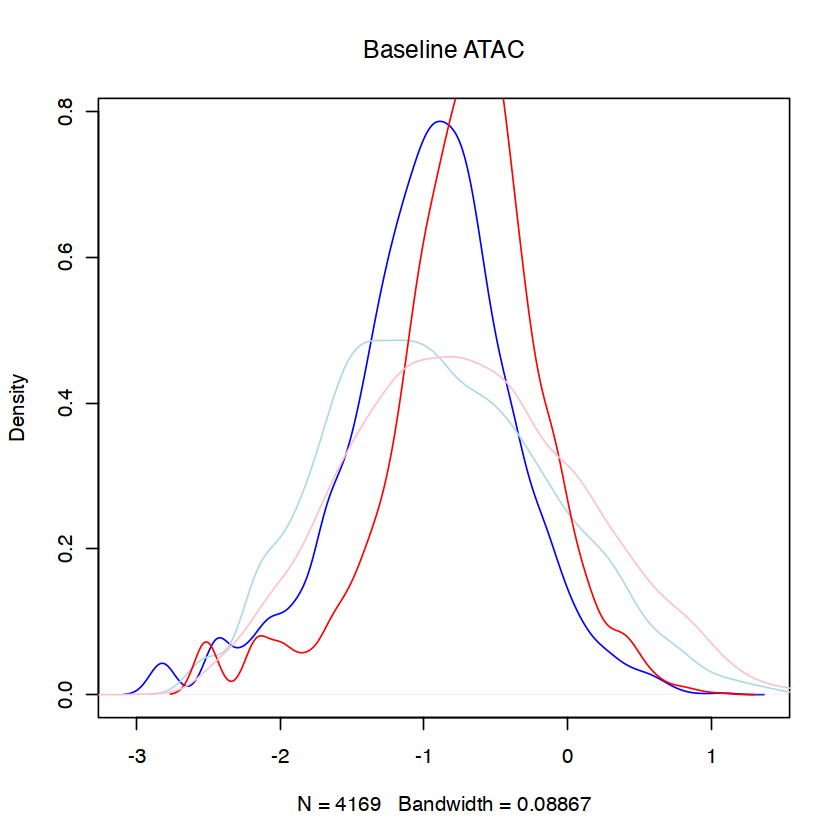

In [113]:
# Plotting the baseline ATAC of peaks that gain ATAC uniquely in each condition 

nh_up = rownames(subset(nh_vs_nd, logFC > 1 & adj.P.Val < 0.05 & rownames(nh_vs_nd) %in% enh_peaks))
#nh_up = rownames(subset(nh_vs_nd, logFC > 1 & adj.P.Val < 0.05))
#nh_up_liberal = rownames(subset(nh_vs_nd, logFC > 0 & rownames(nh_vs_nd) %in% enh_peaks))

ph_up = rownames(subset(ph_vs_pd, logFC > 1 & adj.P.Val < 0.05 & rownames(ph_vs_pd) %in% enh_peaks))
#ph_up = rownames(subset(ph_vs_pd, logFC > 1 & adj.P.Val < 0.05))
#ph_up_liberal = rownames(subset(ph_vs_pd, logFC > 0 & rownames(ph_vs_pd) %in% enh_peaks))

nh_up_only = setdiff(nh_up, ph_up)   # 4169
ph_up_only = setdiff(ph_up, nh_up)   # 2654
nh_ph_shared = intersect(nh_up, ph_up)

# nh_up_only = setdiff(nh_up, ph_up_liberal)   # 4646
# ph_up_only = setdiff(ph_up, nh_up_liberal)   # 3013

# baseline ATAC in sgNTC for peaks up in sgNTC HU only
plot(density(apply(zsc_norm_expr[nh_up_only,1:2], 1, mean)), col="blue", main="Baseline ATAC")  

# baseline ATAC in sgSpi1 for peaks up in sgNTC HU only
lines(density(apply(zsc_norm_expr[nh_up_only,7:8], 1, mean)), col="lightblue")

# baseline ATAC in sgSpi1 for peaks up in sgSpi1 HU only
lines(density(apply(zsc_norm_expr[ph_up_only,7:8], 1, mean)), col="red")

# baseline ATAC in sgNTC for peaks up in sgSpi1 HU only
lines(density(apply(zsc_norm_expr[ph_up_only,1:2], 1, mean)), col="pink")


# I am trying to show that peaks that are gained during HU treatment in each background are primed, that is they have a higher ATAC 
# in general there is a group of peaks whose baseline ATAC is lower in the other cell type, consistent with this
# but there is also a population of peaks whose increase is unique to each background because they are already high in the other background 

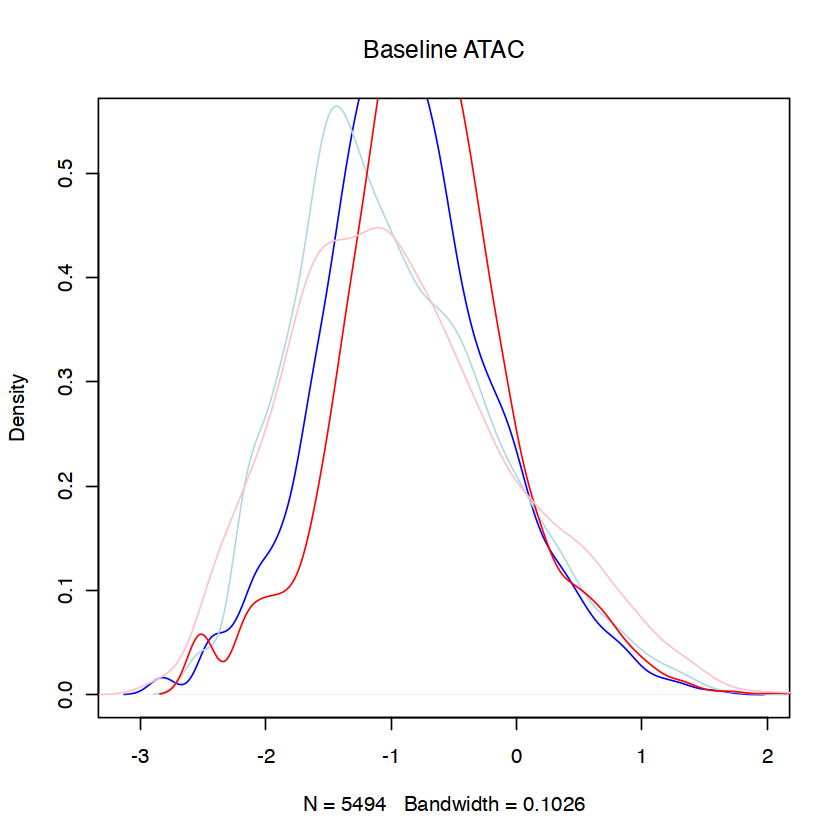

In [114]:
# is this true for -E2 also?
# for -E2, the baseline ATAC for peaks that go up in each background is higher in that background than in the other background, 
# indicating that that when Hoxa9 is removed, you turn on loci that already have a bit of ATAC signal (because of existing TFs)

ne_up = rownames(subset(ne_vs_nd, logFC > 1 & adj.P.Val < 0.05 & rownames(ne_vs_nd) %in% enh_peaks))
#ne_up = rownames(subset(ne_vs_nd, logFC > 1 & adj.P.Val < 0.05))
#nh_up_liberal = rownames(subset(nh_vs_nd, logFC > 0 & rownames(nh_vs_nd) %in% enh_peaks))

pe_up = rownames(subset(pe_vs_pd, logFC > 1 & adj.P.Val < 0.05 & rownames(pe_vs_pd) %in% enh_peaks))
#pe_up = rownames(subset(pe_vs_pd, logFC > 1 & adj.P.Val < 0.05))
#ph_up_liberal = rownames(subset(ph_vs_pd, logFC > 0 & rownames(ph_vs_pd) %in% enh_peaks))

ne_up_only = setdiff(ne_up, pe_up)   # 4169
pe_up_only = setdiff(pe_up, ne_up)   # 2654
ne_pe_shared = intersect(pe_up, ne_up)

# nh_up_only = setdiff(nh_up, ph_up_liberal)   # 4646
# ph_up_only = setdiff(ph_up, nh_up_liberal)   # 3013

# baseline ATAC in sgNTC for peaks up in sgNTC HU only
plot(density(apply(zsc_norm_expr[ne_up_only,1:2], 1, mean)), col="blue", main="Baseline ATAC", ylim=c(0,0.55))  

# baseline ATAC in sgSpi1 for peaks up in sgNTC HU only
lines(density(apply(zsc_norm_expr[ne_up_only,7:8], 1, mean)), col="lightblue")

# baseline ATAC in sgSpi1 for peaks up in sgSpi1 HU only
lines(density(apply(zsc_norm_expr[pe_up_only,7:8], 1, mean)), col="red")

# baseline ATAC in sgNTC for peaks up in sgSpi1 HU only
lines(density(apply(zsc_norm_expr[pe_up_only,1:2], 1, mean)), col="pink")


In [ ]:
# is this true for -E2 also?
# for -E2, the baseline ATAC for peaks that go up in each background is higher in that background than in the other background, 
# indicating that that when Hoxa9 is removed, you turn on loci that already have a bit of ATAC signal (because of existing TFs)

ne_up = rownames(subset(ne_vs_nd, logFC > 1 & adj.P.Val < 0.05 & rownames(ne_vs_nd) %in% enh_peaks))
#ne_up = rownames(subset(ne_vs_nd, logFC > 1 & adj.P.Val < 0.05))
#nh_up_liberal = rownames(subset(nh_vs_nd, logFC > 0 & rownames(nh_vs_nd) %in% enh_peaks))

pe_up = rownames(subset(pe_vs_pd, logFC > 1 & adj.P.Val < 0.05 & rownames(pe_vs_pd) %in% enh_peaks))
#pe_up = rownames(subset(pe_vs_pd, logFC > 1 & adj.P.Val < 0.05))
#ph_up_liberal = rownames(subset(ph_vs_pd, logFC > 0 & rownames(ph_vs_pd) %in% enh_peaks))

ne_up_only = setdiff(ne_up, pe_up)   # 4169
pe_up_only = setdiff(pe_up, ne_up)   # 2654
ne_pe_shared = intersect(pe_up, ne_up)

# nh_up_only = setdiff(nh_up, ph_up_liberal)   # 4646
# ph_up_only = setdiff(ph_up, nh_up_liberal)   # 3013

# baseline ATAC in sgNTC for peaks up in sgNTC HU only
plot(density(apply(norm_expr[ne_up_only,1:2], 1, mean)), col="blue", main="Baseline ATAC", ylim=c(0,0.55))  

# baseline ATAC in sgSpi1 for peaks up in sgNTC HU only
lines(density(apply(norm_expr[ne_up_only,7:8], 1, mean)), col="lightblue")

# baseline ATAC in sgSpi1 for peaks up in sgSpi1 HU only
lines(density(apply(norm_expr[pe_up_only,7:8], 1, mean)), col="red")

# baseline ATAC in sgNTC for peaks up in sgSpi1 HU only
lines(density(apply(norm_expr[pe_up_only,1:2], 1, mean)), col="pink")

# baseline ATAC in sgNTC and sgSpi1 for shared peaks -- kind of intermediate
lines(density(apply(norm_expr[ne_pe_shared,1:2], 1, mean)), col="green")
lines(density(apply(norm_expr[ne_pe_shared,7:8], 1, mean)), col="purple")



In [98]:
nh_only = setdiff(nh_up, ne_up)  # 2756
shared_n = intersect(nh_up, ne_up)  # 2692
ne_only = setdiff(ne_up, nh_up)  # 7222

ph_only = setdiff(ph_up, pe_up)  # 2172
shared_p = intersect(ph_up, pe_up)  # 1761
pe_only = setdiff(pe_up, ph_up)  # 5189

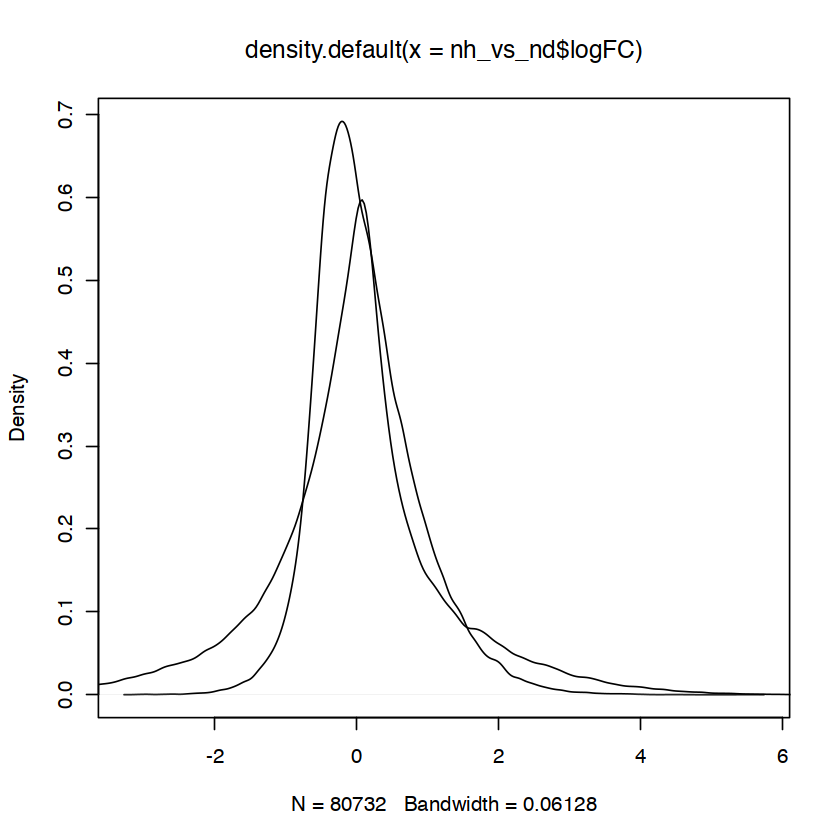

In [99]:
plot(density(nh_vs_nd$logFC))
lines(density(ne_vs_nd$logFC))

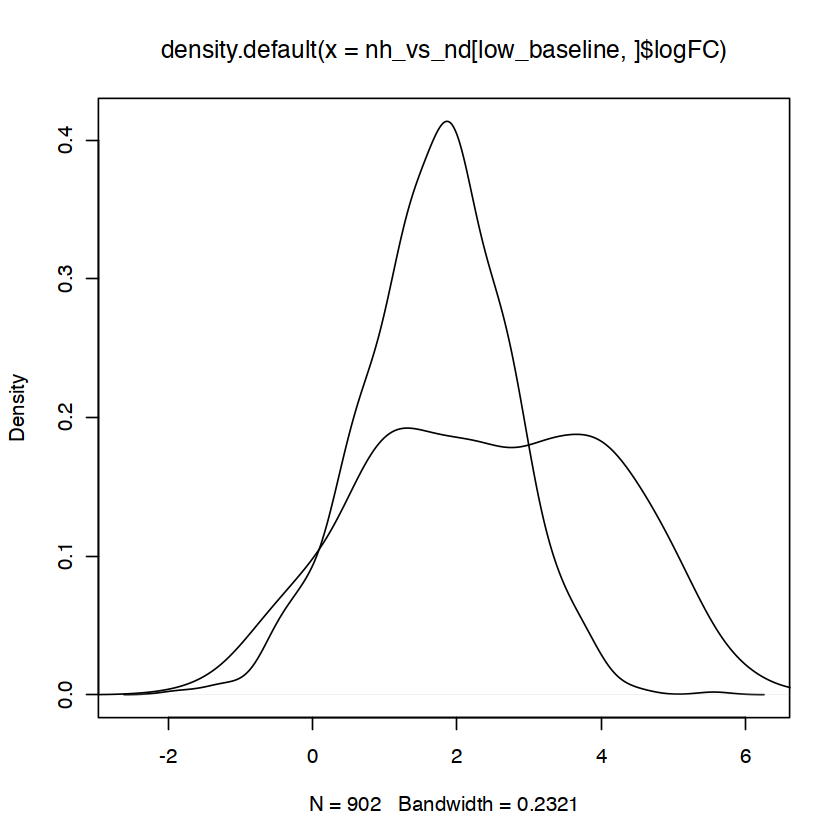

In [100]:
low_baseline = rownames(subset(norm_expr, nd1 < -2))
plot(density(nh_vs_nd[low_baseline,]$logFC))
lines(density(ne_vs_nd[low_baseline,]$logFC))

In [101]:
sum(apply(norm_expr[nh_only,1:2], 1, mean) < -2)/length(nh_only)
sum(apply(norm_expr[ne_only,1:2], 1, mean) < -2)/length(ne_only)

[1] 0.03628447

[1] 0.06300194

In [102]:
sum(apply(norm_expr[ph_only,7:8], 1, mean) < -2)/length(ph_only)
sum(apply(norm_expr[pe_only,7:8], 1, mean) < -2)/length(pe_only)

[1] 0.03084715

[1] 0.1106186

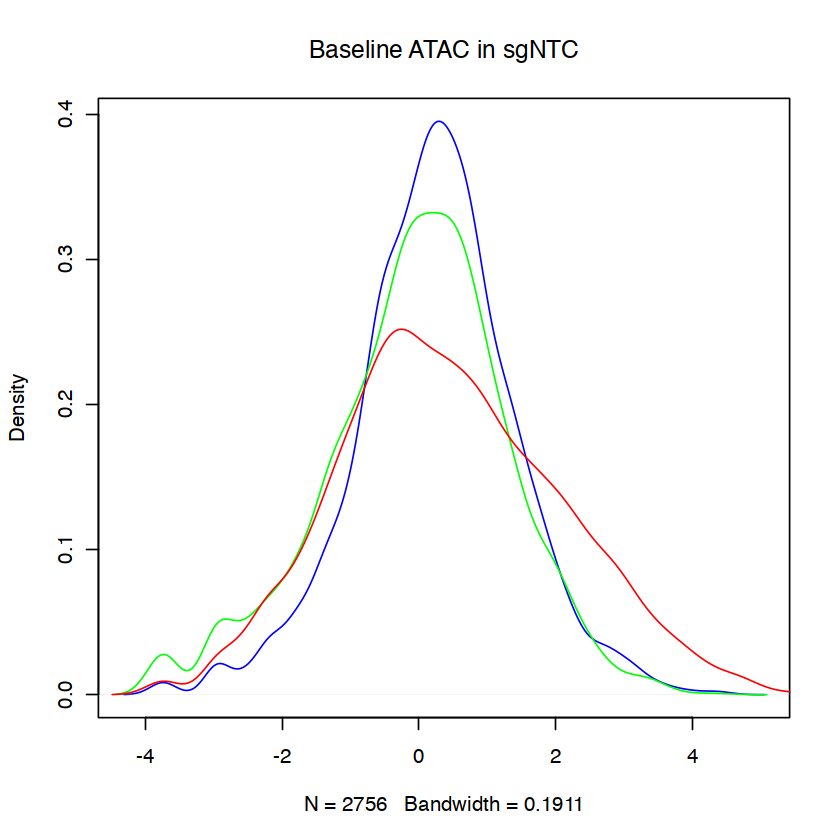

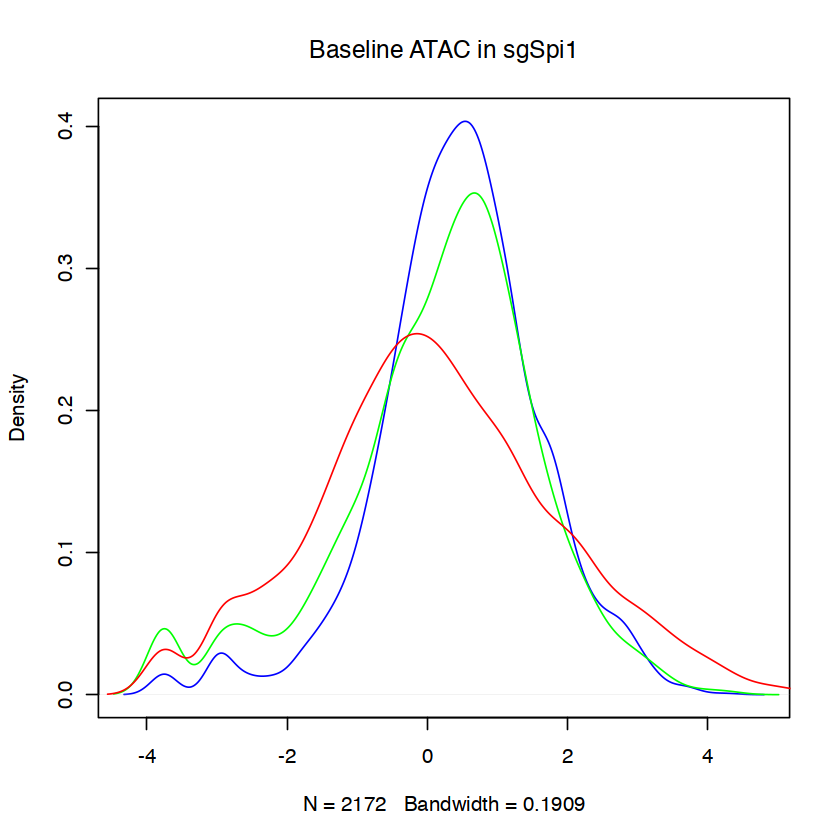

In [103]:
# Plotting baseline ATAC for peaks that gain ATAC in HU vs -E2
# clearly -E2 enables induction of peaks with very low ATAC whereas 
# HU induces peaks with medium ATAC
# not really sure what's going on with the peaks with high ATAC
# this suggests that peaks with high baseline ATAC go even higher in -E2, but not HU 

plot(density(apply(norm_expr[nh_only,1:2], 1, mean)), col="blue", main="Baseline ATAC in sgNTC")
lines(density(apply(norm_expr[shared_n,1:2], 1, mean)), col="green")
lines(density(apply(norm_expr[ne_only,1:2], 1, mean)), col="red")

plot(density(apply(norm_expr[ph_only,7:8], 1, mean)), col="blue", main="Baseline ATAC in sgSpi1")
lines(density(apply(norm_expr[shared_p,7:8], 1, mean)), col="green")
lines(density(apply(norm_expr[pe_only,7:8], 1, mean)), col="red")

## ChromVAR

In [4]:
library(chromVAR)
library(motifmatchr)
library(chromVARmotifs)
library(Matrix)
library(SummarizedExperiment)
library(BiocParallel)
library(BSgenome.Mmusculus.UCSC.mm10)
register(MulticoreParam(4, progressbar = TRUE))
set.seed(2017)

ERROR: Error in library(chromVAR): there is no package called ‘chromVAR’


In [21]:
# use normalized peak counts -- 

peaks = makeGRangesFromDataFrame(peak_info[,1:4])
count_matrix = as.matrix(df)

# fragment_counts_brq = SummarizedExperiment(assays = list(counts = count_matrix_brq),
#                                        rowRanges = peaks)
# fragment_counts_e2w = SummarizedExperiment(assays = list(counts = count_matrix_e2w),
#                                                          rowRanges = peaks)
fragment_counts = SummarizedExperiment(assays = list(counts = count_matrix),
                                                         rowRanges = peaks)

In [236]:
get_motifs = function(peak_names) {
    peak_subset = makeGRangesFromDataFrame(peak_info[peak_names,1:4])
    count_matrix_subset = as.matrix(df[peak_names,])
    fragment_counts_subset = SummarizedExperiment(assays = list(counts = count_matrix_subset),
                                                         rowRanges = peak_subset)
    fragment_counts_subset <- addGCBias(fragment_counts_subset, genome = BSgenome.Mmusculus.UCSC.mm10)
    dev_mouse_subset = get_deviations(fragment_counts_subset, mouse_pwms_v2)
    dev_mouse_vals_subset = get_values(fragment_counts_subset, dev_mouse_subset, names(df[peak_names,]), pct=FALSE)
    return(dev_mouse_vals_subset)
}

In [23]:
fragment_counts <- addGCBias(fragment_counts, genome = BSgenome.Mmusculus.UCSC.mm10)
data("mouse_pwms_v2") # mouse collection from greenleaf lab

In [10]:
get_deviations = function(data, motif_set) {
  motif_ix <- matchMotifs(motif_set, data,  genome = BSgenome.Mmusculus.UCSC.mm10)
  dev <- computeDeviations(object = data, annotations = motif_ix)
  return(dev)
}

# ordered by variability
get_values = function(data, dev, column_names, num_motifs=-1, pct=FALSE) {
  dev_deviations = deviations(dev)
  dev_zsc = deviationScores(dev)
  
  variability <- computeVariability(dev)
  
  if(num_motifs == -1) num_motifs = dim(variability)[1]
  highly_variable = variability[order(-variability[,"variability"]),][1:num_motifs,]
  dev_highvar = dev_deviations[rownames(highly_variable),]
  colnames(dev_highvar)= column_names
  if(!pct) return(dev_highvar)

  #rownames(dev_highvar) = highly_variable$name
  dev_highvar_pct = t(apply(dev_highvar,1,function(x) (x - min(x))/(max(x) - min(x))))
  return(dev_highvar_pct)
}

# ordered by when the motif is maximallly open
order_by_max = function(dev) {
  dev_order = apply(dev,1,which.max)
  return(dev[order(dev_order),])
}

melt_df = function(data) {
  dev_highvar_melt = melt(data)
  colnames(dev_highvar_melt) = c("Motif", "Timepoint", "Pct")
  return(dev_highvar_melt)
}

chname = function(x) {
  x = sub("XP_", "XP", x)
  x = sub("NP_", "NP", x)
  return(x)
}


In [26]:
dev_mouse = get_deviations(fragment_counts, mouse_pwms_v2)
dev_mouse_vals = get_values(fragment_counts, dev_mouse, names(df), pct=FALSE)
dev_mouse_pct = get_values(fragment_counts, dev_mouse, names(df), pct=TRUE)

  |======================================================================| 100%

  |======================================================================| 100%

  |======================================================================| 100%



In [29]:
write.table(dev_mouse_vals, "../output/221107_all_chromvar_mouse.csv", sep=',', quote=FALSE)


In [127]:
library(stringr)

In [5]:
dev_mouse_vals = read.csv("../output/221107_all_chromvar_mouse.csv")

rownames(dev_mouse_vals) = make.names(sapply(rownames(dev_mouse_vals), 
                                      function(x) {strsplit(x, '_')[[1]][3]}), unique=T)
dev_mouse_vals = dev_mouse_vals[!duplicated(rownames(dev_mouse_vals)),]


In [6]:
rownames(dev_mouse_pct) = sapply(rownames(dev_mouse_pct), 
                                     function(x) {strsplit(chname(x), '_')[[1]][3]})
rownames(dev_mouse_vals) = sapply(rownames(dev_mouse_vals), 
                                      function(x) {strsplit(chname(x), '_')[[1]][3]})
dev_mouse_pct = dev_mouse_pct[!duplicated(rownames(dev_mouse_pct)),]
dev_mouse_vals = dev_mouse_vals[!duplicated(rownames(dev_mouse_vals)),]


ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'X' in selecting a method for function 'sapply': error in evaluating the argument 'x' in selecting a method for function 'rownames': object 'dev_mouse_pct' not found


In [7]:
dev_mouse_vals["Cebpa",]

,nd1,nd2,ne1,ne2,nh1,nh2,pd1,pd2,pe1,pe2,ph1,ph2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Cebpa,-0.02195634,-0.02635753,0.09553155,0.08356273,-0.02022851,-0.02644314,-0.03882282,-0.03554662,0.003625183,-0.003742031,-0.004352525,-0.009393595


Warning message:
“The input is a data frame, convert it to a matrix.”


pdf 
  2

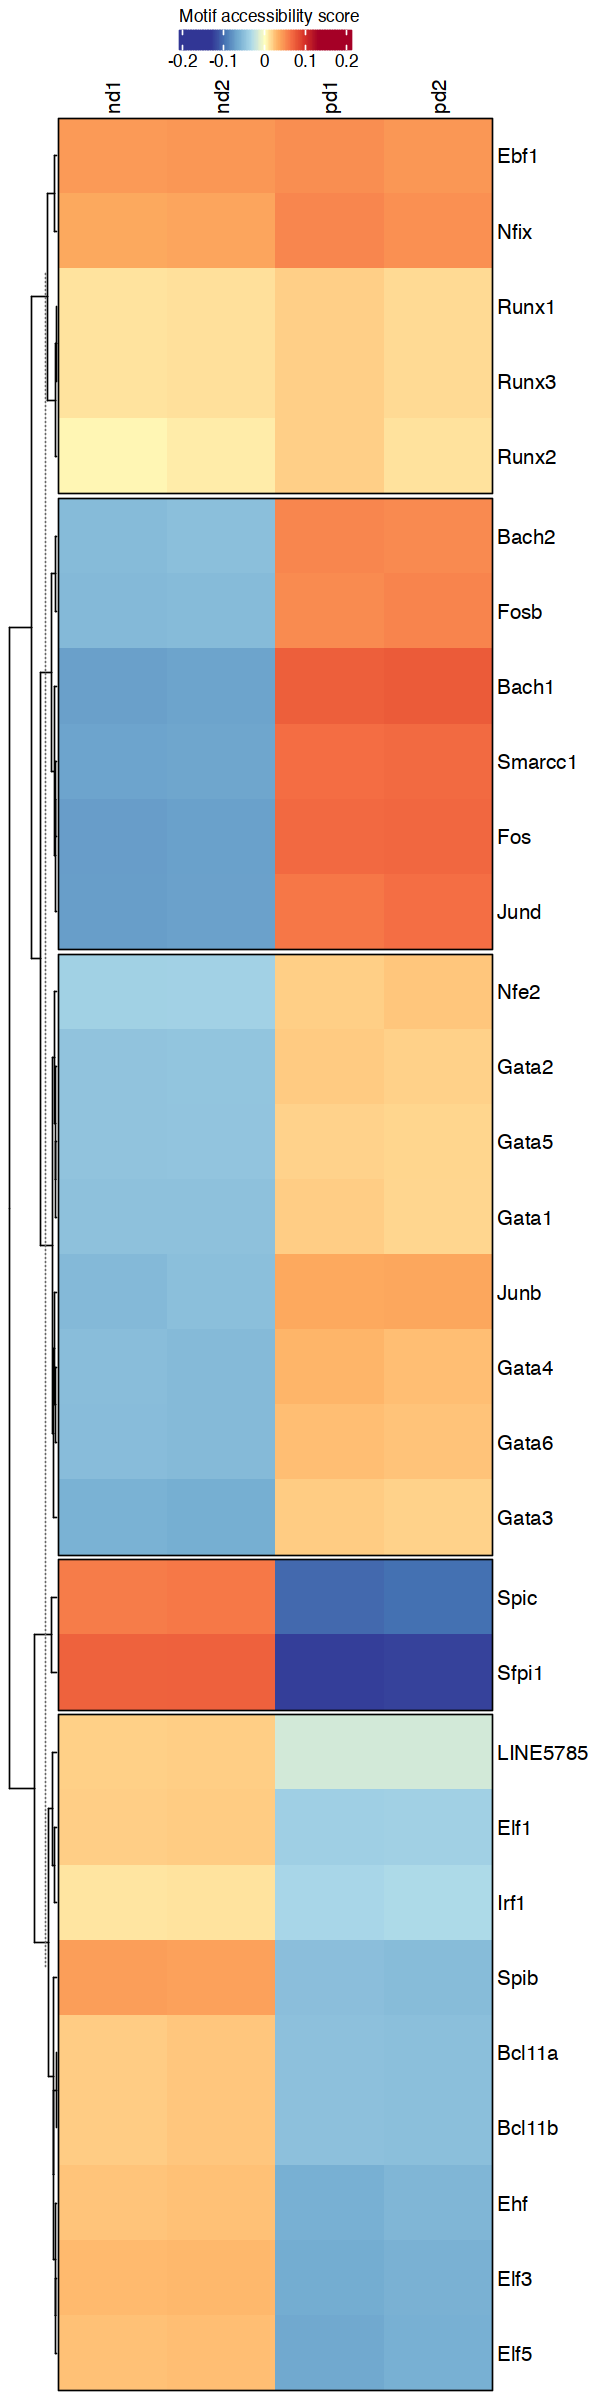

In [12]:
# Plotting top 30 motifs 
options(repr.plot.width=5, repr.plot.height=20)

dev_mouse_vals_reorder = dev_mouse_vals[,c(1,2,5,6,3,4,7,8,11,12,9,10)]
dev_mouse_vals_reorder_dmso_only = dev_mouse_vals[,c(1,2,7,8)]
h = Heatmap(head(dev_mouse_vals_reorder_dmso_only,30), 
        cluster_columns = F, 
        cluster_rows = T,
        column_names_side = "top", 
        column_title=NULL,
        row_title=NULL,
        border=T,
        row_km=6, row_km_repeats = 1000,
        col = colorRamp2(seq(-0.13, 0.13, length.out = 9), 
                         rev(RColorBrewer::brewer.pal(name = "RdYlBu", n = 11))[c(1:4, 6, 8:11)]),
       heatmap_legend_param = list(title="Motif accessibility score",
                                   direction="horizontal"))

draw(h, heatmap_legend_side="top")


pdf("../output/230930_bd355_chromvar_dmso_only.pdf", width=2, height=6)
draw(h, heatmap_legend_side="bottom")
dev.off()


In [110]:
z = dev_mouse_vals 
sum(z[,"nh1"] + z[,"nh2"] - z[,"nd1"] - z[,"nd2"] > 0)
sum(z[,"nh1"] + z[,"nh2"] - z[,"nd1"] - z[,"nd2"] < 0)
sum(z[,"ph1"] + z[,"ph2"] - z[,"pd1"] - z[,"pd2"] > 0)
sum(z[,"ph1"] + z[,"ph2"] - z[,"pd1"] - z[,"pd2"] < 0)

sum(z[,"ne1"] + z[,"ne2"] - z[,"nd1"] - z[,"nd2"] > 0)
sum(z[,"ne1"] + z[,"ne2"] - z[,"nd1"] - z[,"nd2"] < 0)
sum(z[,"pe1"] + z[,"pe2"] - z[,"pd1"] - z[,"pd2"] > 0)
sum(z[,"pe1"] + z[,"pe2"] - z[,"pd1"] - z[,"pd2"] < 0)

[1] 732

[1] 68

[1] 719

[1] 81

[1] 439

[1] 361

[1] 385

[1] 415

In [31]:
dev_mouse_vals

,nd1,nd2,ne1,ne2,nh1,nh2,pd1,pd2,pe1,pe2,ph1,ph2
Sfpi1,0.071351669,0.072105915,0.137005970,0.140327808,0.1328425508,0.122818311,-0.12610676,-0.12370213,-0.102936081,-0.101159009,-0.11134692,-0.11228957
Spic,0.058032416,0.059992583,0.117369412,0.116393597,0.1065538510,0.097651043,-0.10355680,-0.09972657,-0.083681372,-0.079965799,-0.09307822,-0.09440132
Spib,0.040774433,0.039077982,0.047474949,0.045738941,0.0751190217,0.064895273,-0.05196639,-0.05408691,-0.065924124,-0.066979972,-0.04175006,-0.04370584
Bcl11a,0.020290419,0.022780519,0.048332213,0.047670976,0.0645508701,0.056211360,-0.05077209,-0.05167701,-0.050644471,-0.054217662,-0.03300102,-0.03327724
Bcl11b,0.020290419,0.022780519,0.048332213,0.047670976,0.0645508701,0.056211360,-0.05077209,-0.05167701,-0.050644471,-0.054217662,-0.03300102,-0.03327724
Smarcc1,-0.070011790,-0.068947437,-0.088868028,-0.089305098,-0.0145810372,-0.006120937,0.06496711,0.06679629,-0.031715944,-0.036211329,0.10587900,0.10814539
Elf5,0.025018774,0.026129624,0.075207446,0.074105803,0.0592749805,0.058143500,-0.06697704,-0.06256067,-0.040182595,-0.037636806,-0.05471463,-0.05345844
Fos,-0.074130009,-0.072030110,-0.091565444,-0.091964191,-0.0152314896,-0.007643194,0.06733120,0.06886119,-0.035674465,-0.037084016,0.11157936,0.11442730
Elf3,0.027790451,0.028538592,0.071336687,0.071808876,0.0582782904,0.057101813,-0.06513716,-0.06180458,-0.039552898,-0.037712494,-0.05467830,-0.05320528
Bach1,-0.072629637,-0.070237097,-0.096793189,-0.097661481,-0.0180737815,-0.006941265,0.07362355,0.07587485,-0.035897052,-0.038745944,0.11143862,0.11414877


In [ ]:
# Plotting top 30 motifs 
options(repr.plot.width=5, repr.plot.height=14)

#dev_mouse_vals = read.csv("../data/210629_all_chromvar_mouse.csv")

dev_mouse_vals_mean = (dev_mouse_vals[,(c(1:14)*2 - 1)] + dev_mouse_vals[,(c(1:14)*2)])/2
colnames(dev_mouse_vals_mean) = c(0, 4, 8, 12, 24, 36, 48, 0, 4, 8, 12, 24, 36, 48)
h = Heatmap(head(dev_mouse_vals_mean,30), 
        cluster_columns = F, 
        # cluster_rows = F,
        column_names_side = "top", 
        column_title=NULL,
        row_title=NULL,
        border=T,
        row_km=6, row_km_repeats = 100,
        column_split = c(rep("BRQ", 7), rep("E2", 7)),
        col = colorRamp2(seq(-0.08, 0.08, length.out = 9), 
                         rev(RColorBrewer::brewer.pal(name = "RdYlBu", n = 11))[c(1:4, 6, 8:11)]),
       heatmap_legend_param = list(title="Motif accessibility score",
                                   direction="horizontal"))

draw(h, heatmap_legend_side="top")


pdf("../output/220608_633_atac_top30.pdf", width=4, height=6)
draw(h, heatmap_legend_side="bottom")
dev.off()


## Associations with repeat elements

In [214]:
ph_up = subset(ph_vs_pd, logFC > 1 & adj.P.Val < 0.05)  # 3668
nh_up = subset(nh_vs_nd, logFC > 1 & adj.P.Val < 0.05)  # 4727
pe_up = subset(pe_vs_pd, logFC > 1 & adj.P.Val < 0.05)  # 3668
ne_up = subset(ne_vs_nd, logFC > 1 & adj.P.Val < 0.05)  # 4727

In [215]:
ph_not_pe = setdiff(rownames(ph_up), rownames(pe_up))
nh_not_ne = setdiff(rownames(nh_up), rownames(ne_up))
length(ph_not_pe)
length(nh_not_ne)
comb_hu_up = intersect(ph_not_pe, nh_not_ne)
length(comb_hu_up)

[1] 1915

[1] 2213

[1] 450

In [218]:
pe_not_ph = setdiff(rownames(pe_up), rownames(ph_up))
ne_not_nh = setdiff(rownames(ne_up), rownames(nh_up))
length(pe_not_ph)
length(ne_not_nh)


[1] 5147

[1] 6828

In [175]:
# read repeat file
#repeat_file = read.table("~/Documents/bigwigs/er-hoxa9/mm10_repeats.sorted.bed")
repeat_df = makeGRangesFromDataFrame(repeat_file, start.field="V2", end.field="V3", seqnames.field="V1", keep.extra.columns=T)
head(repeat_df)

GRanges object with 6 ranges and 3 metadata columns:
      seqnames          ranges strand |          V4        V5          V6
         <Rle>       <IRanges>  <Rle> | <character> <integer> <character>
  [1]     chr1 3000000-3002128      * |     L1_Mus3     12955           -
  [2]     chr1 3003152-3003994      * |      L1Md_F      1216           -
  [3]     chr1 3003993-3004054      * |     L1_Mus3       234           -
  [4]     chr1 3004040-3004206      * |      L1_Rod      3685           +
  [5]     chr1 3004206-3004270      * |     (CAAA)n       376           +
  [6]     chr1 3004270-3005001      * |      L1_Rod      3685           +
  -------
  seqinfo: 239 sequences from an unspecified genome; no seqlengths

In [184]:
repeat_df[overlaps$subjectHits,]

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'i' in selecting a method for function '[': $ operator not defined for this S4 class


In [231]:
ph_up = subset(ph_vs_pd, logFC > 0 & adj.P.Val < 0.05)  # 3668
nh_up = subset(nh_vs_nd, logFC > 0 & adj.P.Val < 0.05)  # 4727
pe_up = subset(pe_vs_pd, logFC > 2 & adj.P.Val < 0.05)  # 3668
ne_up = subset(ne_vs_nd, logFC > 2 & adj.P.Val < 0.05)  # 4727
ne_not_nh = setdiff(rownames(ne_up), rownames(nh_up))
pe_not_ph = setdiff(rownames(pe_up), rownames(ph_up))

overlap_rows = findOverlaps(peaks[pe_not_ph,], repeat_df, ignore.strand = TRUE, select="first")
overlaps = repeat_df[overlap_rows[is.finite(overlap_rows)],]$V4
sum(is.finite(overlap_rows))
length(overlap_rows)
as.data.frame(sort(table(overlaps), decreasing=T))

[1] 1159

[1] 1833

overlaps,Freq
<fct>,<int>
B3,39
ID_B1,36
B4A,28
(TG)n,27
MTA_Mm,26
MIRb,24
Lx8,23
(CA)n,22
MIR,21


In [239]:
vals

,nd1,nd2,ne1,ne2,nh1,nh2,pd1,pd2,pe1,pe2,ph1,ph2
ENSMUSG00000002250_LINE1572_Ppard_I,-0.139117272,-0.228663553,-0.166037444,-0.169691928,-0.08663993,-0.10770779,0.48533104,0.25330775,0.20645201,0.30861947,0.23146575,0.293262556
ENSMUSG00000012350_LINE1015_Ehf_D_N2,0.090296491,0.071031629,0.066807827,0.087230483,0.01910027,0.03016798,-0.11080981,-0.13044983,-0.05757459,-0.06646762,-0.10717218,-0.097330172
ENSMUSG00000027186_LINE1024_Elf5_D_N2,0.090296491,0.071031629,0.066807827,0.087230483,0.01910027,0.03016798,-0.11080981,-0.13044983,-0.05757459,-0.06646762,-0.10717218,-0.097330172
ENSMUSG00000002111_LINE997_Sfpi1_D_N2,0.079477420,0.064640292,0.065141318,0.066160080,0.01953332,0.02294904,-0.09700802,-0.11021804,-0.09119462,-0.03829645,-0.08836925,-0.081949193
ENSMUSG00000048763_LINE1367_Hoxb3_D,0.207522411,0.151954888,0.038156764,0.060219915,0.06210838,0.08564859,-0.38612693,-0.09166217,-0.16729721,-0.13345983,-0.16806295,-0.165658907
ENSMUSG00000030199_LINE1026_Etv6_D,0.222697244,0.176873150,-0.002548343,0.040459726,0.02340854,0.04835944,-0.19912492,-0.11861834,-0.09594186,-0.08473339,-0.13348754,-0.106743889
ENSMUSG00000029249_LINE1131_Rest_I_N10,-0.061543888,-0.141580665,-0.323335811,-0.308943933,-0.04334712,-0.05563953,0.40551197,0.33097622,0.23524814,0.34675001,0.26040789,0.241984138
ENSMUSG00000004359_LINE1005_Spic_D_N1,0.073704885,0.044813735,0.040764366,0.064543839,0.01720691,0.02599034,-0.09269815,-0.08772235,-0.08364421,-0.03797537,-0.07284647,-0.071629571
ENSMUSG00000000861_LINE755_Bcl11a_I,0.004427245,0.021419782,0.087670152,0.081284974,0.01074860,0.02108715,-0.06625167,-0.11801268,-0.03721775,-0.02550816,-0.08304336,-0.062281216
ENSMUSG00000048251_LINE1408_Bcl11b_I,0.004427245,0.021419782,0.087670152,0.081284974,0.01074860,0.02108715,-0.06625167,-0.11801268,-0.03721775,-0.02550816,-0.08304336,-0.062281216


In [242]:
vals = get_motifs(ph_not_pe)
rownames(vals) = sapply(rownames(vals), 
                                      function(x) {strsplit(chname(x), '_')[[1]][3]})
vals = vals[!duplicated(rownames(vals)),]

  |======================================================================| 100%

  |======================================================================| 100%



In [ ]:
h = Heatmap(head(vals,100), 
        cluster_columns = F, 
        cluster_rows = T,
        column_names_side = "top", 
        column_title=NULL,
        row_title=NULL,
        border=T,
        row_km=6, row_km_repeats = 1000,
        col = colorRamp2(seq(-0.3, 0.3, length.out = 9), 
                         rev(RColorBrewer::brewer.pal(name = "RdYlBu", n = 11))[c(1:4, 6, 8:11)]),
       heatmap_legend_param = list(title="Motif accessibility score",
                                   direction="horizontal"))

draw(h, heatmap_legend_side="top")

In [235]:
ph_up[ph_not_pe,]

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
peak82777,3.576085,0.903202120,8.356921,2.268945e-08,8.223445e-06,6.95043920
peak17860,2.011579,1.542603900,7.178946,2.859878e-07,3.558574e-05,6.31748247
peak75454,4.902419,-0.817885403,6.047862,3.860209e-06,1.948899e-04,0.45801978
peak81095,2.513737,-0.622154677,6.021999,4.104208e-06,2.031001e-04,2.88010543
peak29037,4.382811,-1.480228342,5.736472,8.112175e-06,3.216318e-04,0.03562986
peak37144,2.171756,-0.098608705,5.623436,1.064792e-05,3.923139e-04,2.66595300
peak56740,2.023731,0.933595727,5.476496,1.519117e-05,5.035134e-04,2.42069822
peak32819,2.498438,1.277391021,5.380526,1.917889e-05,5.885900e-04,1.79789310
peak57053,2.127692,0.244141725,5.220003,2.836979e-05,7.647330e-04,1.78486965


In [232]:
ph_up = subset(ph_vs_pd, logFC > 2 & adj.P.Val < 0.05)  # 3668
nh_up = subset(nh_vs_nd, logFC > 2 & adj.P.Val < 0.05)  # 4727
pe_up = subset(pe_vs_pd, logFC > 0 & adj.P.Val < 0.05)  # 3668
ne_up = subset(ne_vs_nd, logFC > 0 & adj.P.Val < 0.05)  # 4727
nh_not_ne = setdiff(rownames(nh_up), rownames(ne_up))
ph_not_pe = setdiff(rownames(ph_up), rownames(pe_up))

overlap_rows = findOverlaps(peaks[ph_not_pe,], repeat_df, ignore.strand = TRUE, select="first")
overlaps = repeat_df[overlap_rows[is.finite(overlap_rows)],]$V4
sum(is.finite(overlap_rows))
length(overlap_rows)
as.data.frame(sort(table(overlaps), decreasing=T))

[1] 82

[1] 127

overlaps,Freq
<fct>,<int>
(TG)n,4
B4,4
B4A,3
ID4_,3
(TC)n,2
B1F,2
B3,2
L2,2
Lx8,2


In [168]:
ph_up[comb_hu_up,]

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
peak17189,1.939588,2.86157438,11.752689,4.086413e-11,3.027941e-07,14.768004
peak17192,1.905013,2.93382734,9.639871,1.768404e-09,2.097833e-06,11.498288
peak17801,1.538603,3.74145352,8.633351,1.285857e-08,6.038821e-06,9.796733
peak82777,3.576085,0.90320212,8.356921,2.268945e-08,8.223445e-06,6.950439
peak18219,1.011927,4.49798768,8.031769,4.482936e-08,1.220237e-05,8.744517
peak16258,1.283715,2.28615264,8.005804,4.736336e-08,1.243531e-05,8.623160
peak62145,1.191727,3.75743631,7.948520,5.348919e-08,1.319386e-05,8.495660
peak31662,1.157920,2.46530536,7.895092,5.993830e-08,1.407452e-05,8.391201
peak33176,1.685703,2.10585875,7.825167,6.960802e-08,1.561720e-05,7.929842
